In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os, sys

def get_dir_n_levels_up(path, n):
    # Go up n levels from the given path
    for _ in range(n):
        path = os.path.dirname(path)
    return path


proj_root = get_dir_n_levels_up(os.path.abspath("__file__"), 4)
sys.path.append(proj_root)

print(proj_root)

d:\Work\repos\RL\phd-rl-algos


In [3]:
import numpy as np
from rl_envs_forge.envs.network_graph.network_graph import NetworkGraph

from dqn.opinion_dynamics.utils.experiment import build_environment

from dynamic_programming.opinion_dynamics.algos import compute_average_error, compute_final_average_error, generate_full_control_policy
from dynamic_programming.opinion_dynamics.algo_infinite_horizon import value_iteration, extract_policy, create_state_grid
from dynamic_programming.opinion_dynamics.common.viz import plot_opinions_over_time, visualize_policy_from_env


In [13]:

def run_policy(env, policy, nx, step_duration, max_steps=1000):
    """
    Run the simulation using a given policy with a maximum number of steps.

    Args:
        env: The environment with network properties.
        policy: The control policy to be used.
        nx: Number of grid points per dimension (used for mapping states to grid indices).
        step_duration: Duration of each policy application.
        tolerance: Tolerance for the mean opinion to stop the simulation.
        max_steps: Maximum number of steps to run.

    Returns:
        opinions_over_time: Array of opinions over the entire simulation.
        time_points: Corresponding time points for each opinion snapshot.
        rewards_over_time: Collected rewards at each step.
    """
    N = env.num_agents
    time_points = []
    rewards_over_time = []
    current_time = 0.0
    state, _ = env.reset()
    opinions_over_time = [state]
    grids = create_state_grid(N, nx)

    for step in range(max_steps):
        idx = tuple(np.abs(grids[i] - state[i]).argmin() for i in range(N))
        action = policy.get(idx, np.zeros(N))
        
        # print(action)
        next_state, reward, done, truncated, _ = env.step(action, env.tau)
        
        opinions_over_time.append(next_state.copy())
        rewards_over_time.append(reward)
        time_points.append(current_time)
        # print(f"Step: {step}, Time: {current_time}, Reward: {reward}")
        
        current_time += step_duration
        state = next_state

        if done or truncated:
            print(f"Ran for {step} steps: done={done}, truncated={truncated}")
            break
    
    print(f"Ran for {step} steps: done={done}, truncated={truncated}")
    return np.array(opinions_over_time), np.array(time_points), np.array(rewards_over_time)


c:\Users\Chainsword\anaconda3\envs\phd_rl_algos\Lib\site-packages\rl_envs_forge\envs\network_graph\visualize.py:45: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=sorted_labels, y=sorted_centralities, palette="Blues_d")


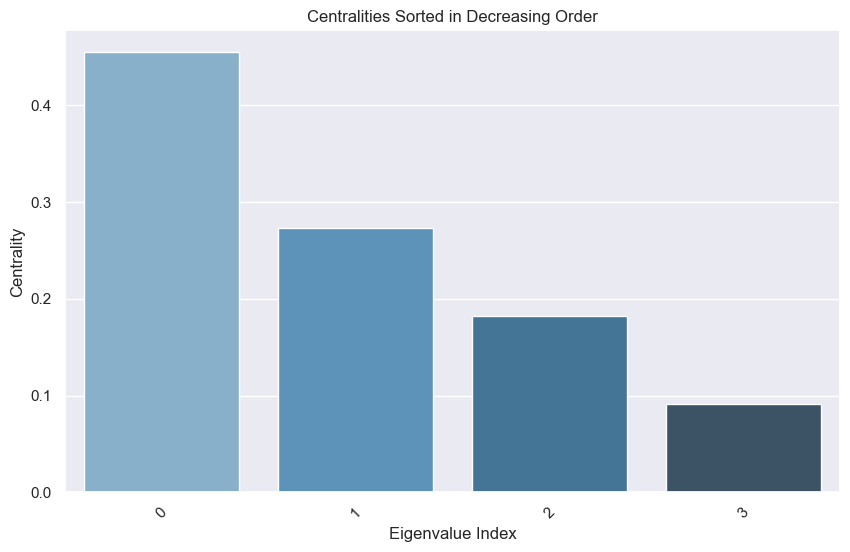

In [5]:
env = build_environment()
env.render(mode="centralities")

Ran for 26 steps: done=True, truncated=False


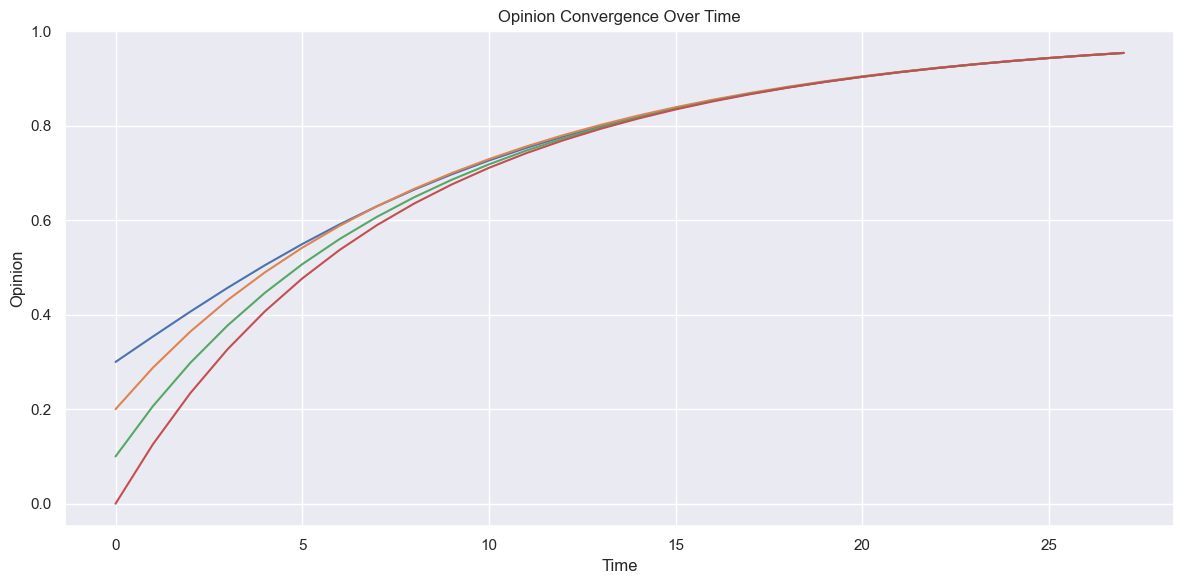

-4.08486868329994

In [6]:

num_steps = 100
nx = 8

policy_broadcast = generate_full_control_policy(env, nx)

opinions_over_time, time_points, rewards = run_policy(env, policy_broadcast, nx=nx, step_duration=env.tau, max_steps=num_steps)
plot_opinions_over_time(opinions_over_time)

# sum(rewards)

gamma = 0.9

total_value = 0
for i, r in enumerate(rewards):
    total_value = total_value + (gamma**i) * r
    
total_value

In [7]:
opinions_over_time

array([[0.3       , 0.2       , 0.1       , 0.        ],
       [0.35368639, 0.28774961, 0.20633883, 0.12564153],
       [0.40630349, 0.36402158, 0.29784974, 0.23371833],
       [0.45683733, 0.43079908, 0.37715661, 0.32680286],
       [0.50466983, 0.48962505, 0.44628375, 0.40713819],
       [0.54945948, 0.54171377, 0.50682491, 0.4766485 ],
       [0.59105674, 0.58803272, 0.56005724, 0.53696695],
       [0.62944369, 0.62936282, 0.60701988, 0.58947031],
       [0.66469077, 0.66634276, 0.64856928, 0.6353146 ],
       [0.69692583, 0.69950193, 0.68541908, 0.67546863],
       [0.72631203, 0.72928479, 0.7181695 , 0.71074406],
       [0.75303206, 0.75606903, 0.7473294 , 0.7418216 ],
       [0.77727712, 0.78017923, 0.77333323, 0.76927327],
       [0.79923924, 0.80189706, 0.79655413, 0.7935811 ],
       [0.81910606, 0.82146911, 0.81731438, 0.81515271],
       [0.83705749, 0.83911278, 0.83589362, 0.83433413],
       [0.8532636 , 0.85502096, 0.85253559, 0.85142037],
       [0.86788345, 0.86936557,

In [8]:
env = build_environment()

# Adjusted parameters
beta = env.control_beta
gamma = 0.9
step_duration = env.tau

V = value_iteration(env, nx=nx, gamma=gamma, beta=beta, step_duration=step_duration)
policy = extract_policy(
    env, V, nx=nx, gamma=gamma, beta=beta, step_duration=step_duration
)
    

Converged in 65 iterations.


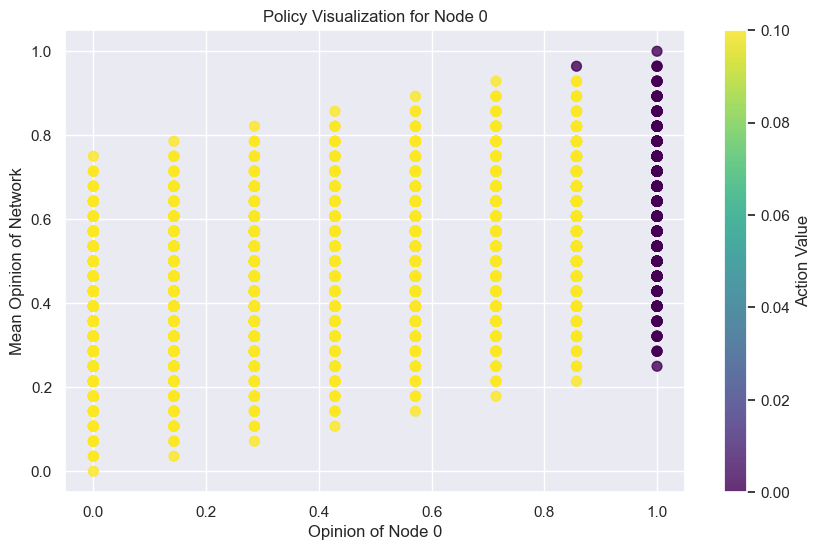

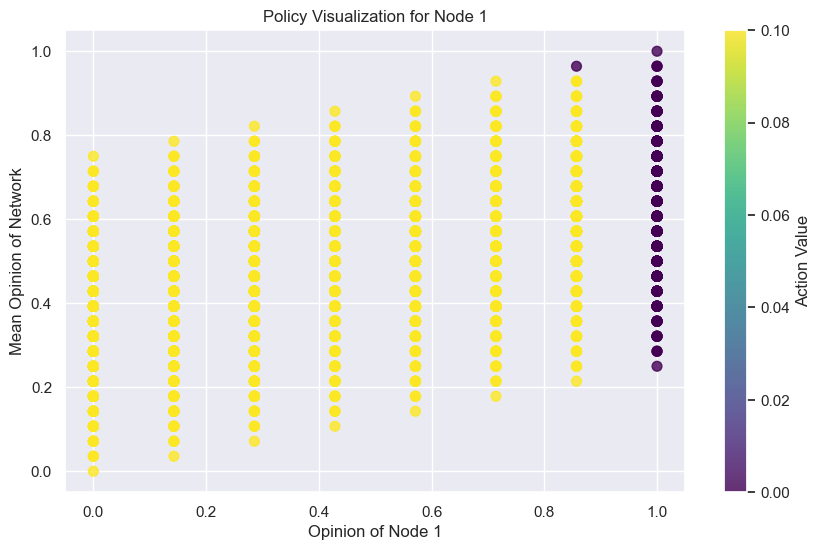

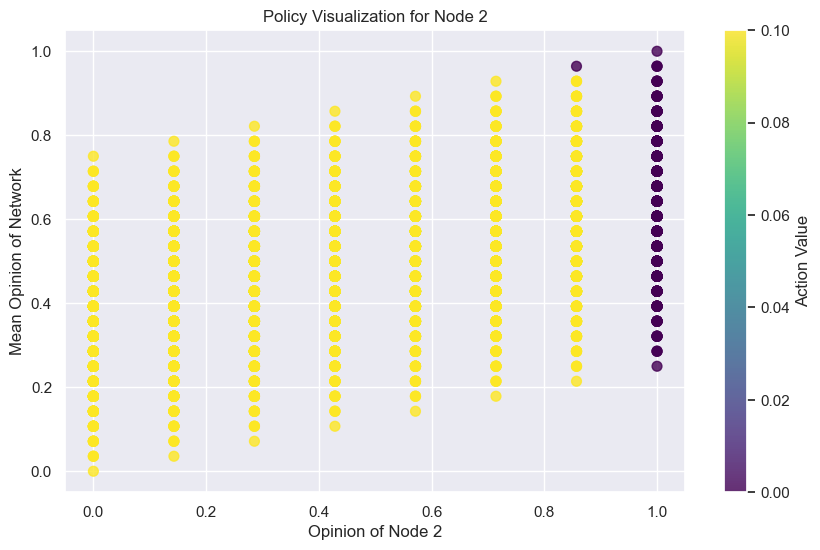

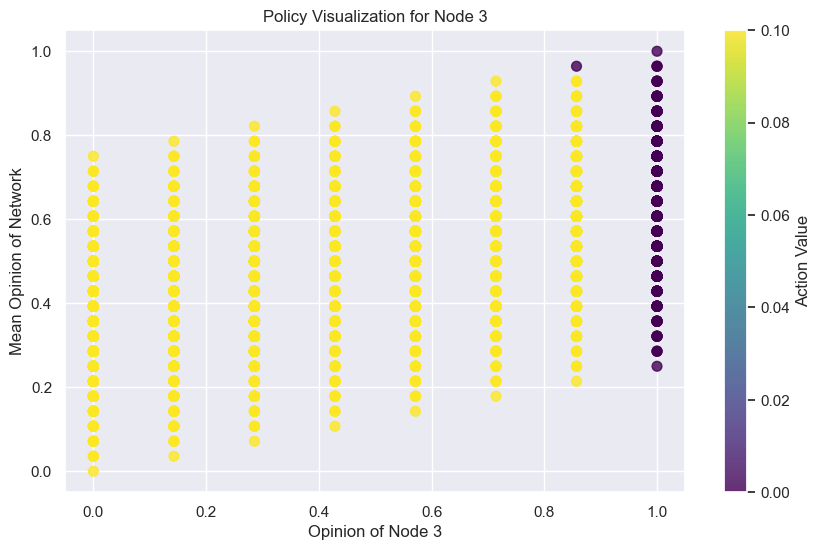

In [9]:
for node_index in range(env.num_agents):
    visualize_policy_from_env(policy, env, nx=nx, node_index=node_index)

Ran for 29 steps: done=False, truncated=False


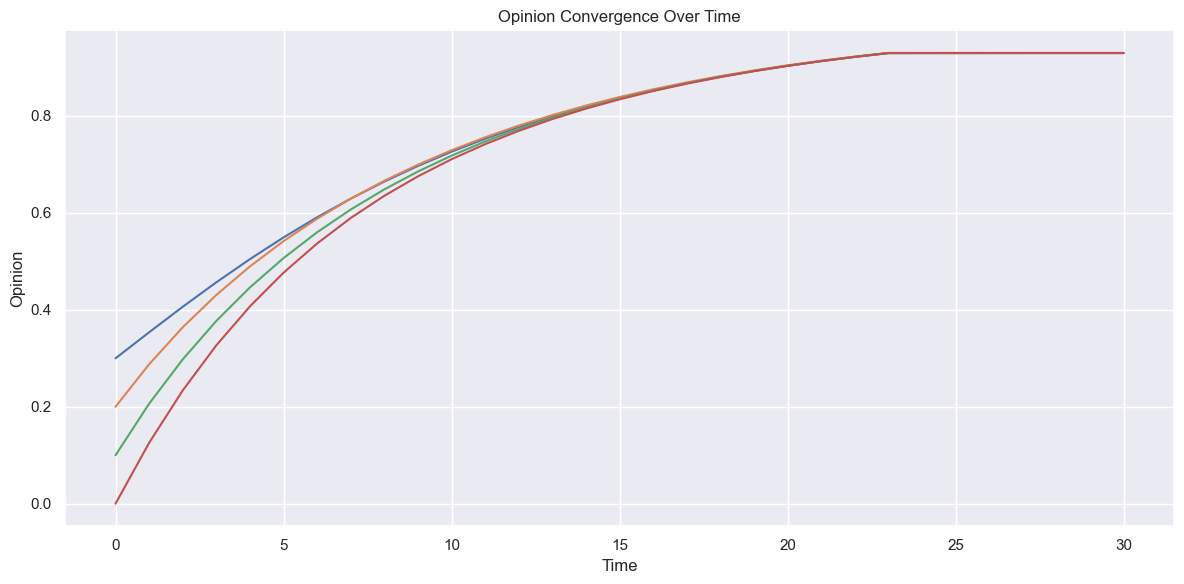

-4.088191747763184

In [16]:
env = build_environment()
num_steps = 30

opinions_over_time, time_points, rewards = run_policy(env, policy, nx=nx, step_duration=env.tau, max_steps=num_steps)
plot_opinions_over_time(opinions_over_time)
# sum(rewards)

total_value = 0
for i, r in enumerate(rewards):
    total_value = total_value + (gamma**i) * r
    
total_value

In [11]:
env.opinions

array([0.92978496, 0.93013041, 0.92987752, 0.92985332])

In [12]:
rewards

array([-0.76600568, -0.68704492, -0.61740483, -0.5558373 , -0.50128686,
       -0.4528573 , -0.40978445, -0.37141408, -0.33718378, -0.30660808,
       -0.27926632, -0.25479258, -0.23286742, -0.213211  , -0.1955774 ,
       -0.17974987, -0.16553686, -0.15276866, -0.14129457, -0.13098056,
       -0.12170716, -0.11336775, -0.10586705, -0.06739807, -0.06739274])

### DQN: 
Distributes budget beta_k (beta can be selected from discrete interval) across all nodes using W*
beta_k to be chosen constant

###  NAHS 
Distributes total budget B across M campaigns
At each campaign distributes the budget beta_k across all nodes using W_k
distribute the same beta_k as in the dqn experiment, and track